In [ ]:
# %load Forecasting_Data_Driven_Approaches.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
from datetime import datetime,time
#from sm.tsa.statespace import sa
Amtrak = pd.read_csv("C:\\Users\\Hi\\Desktop\\Datascience trainer's Kit\\21 Forecasting\\Dataset\\Amtrak.csv")

Amtrak.rename(columns={"Ridership ('000)":"Ridership"},inplace=True)   
# Converting the normal index of Amtrak to time stamp 


Amtrak.Ridership.plot() # time series plot 
# Creating a Date column to store the actual Date format for the given Month column
Amtrak["Date"] = pd.to_datetime(Amtrak.Month,format="%b-%y")
#look for c standard format codes

# Extracting Day, weekday name, month name, year from the Date column using 
# Date functions from pandas 

Amtrak["month"] = Amtrak.Date.dt.strftime("%b") # month extraction
#Amtrak["Day"] = Amtrak.Date.dt.strftime("%d") # Day extraction
#Amtrak["wkday"] = Amtrak.Date.dt.strftime("%A") # weekday extraction
Amtrak["year"] = Amtrak.Date.dt.strftime("%Y") # year extraction

# Some EDA on Time series data 
# Heat map visualization 
heatmap_y_month = pd.pivot_table(data=Amtrak,values="Ridership",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

# Boxplot for ever
sns.boxplot(x="month",y="Ridership",data=Amtrak)
sns.boxplot(x="year",y="Ridership",data=Amtrak)
# sns.factorplot("month","Ridership",data=Amtrak,kind="box")

# Line plot for Ridership based on year
sns.lineplot(x="year",y="Ridership",data=Amtrak)


# Centering moving average for the time series to understand better about the trend character in Amtrak
Amtrak.Ridership.plot(label="org")
for i in range(2,24,6):
    Amtrak["Ridership"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)
    
# Time series decomposition plot 
decompose_ts_add = seasonal_decompose(Amtrak.Ridership,model="additive",freq=12)
decompose_ts_add.plot()
decompose_ts_mul = seasonal_decompose(Amtrak.Ridership,model="multiplicative",freq=12)
decompose_ts_mul.plot()

# ACF plots and PACF plots on Original data sets 
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(Amtrak.Ridership,lags=12)
tsa_plots.plot_pacf(Amtrak.Ridership,lags=12)

# Amtrak.index.freq = "MS" 
# splitting the data into Train and Test data and considering the last 12 months data as 
# Test data and left over data as train data 

Train = Amtrak.head(147)
Test = Amtrak.tail(12)
# to change the index value in pandas data frame 
# Test.set_index(np.arange(1,13),inplace=True)

# Creating a function to calculate the MAPE value for test data 
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)


# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Ridership"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Ridership) # 7.846321

# Holt method 
hw_model = Holt(Train["Ridership"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Ridership) # 7.261176729658341



# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Ridership"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Ridership) # 4.500954

hwe_model_add_add = ExponentialSmoothing(Amtrak["Ridership"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Amtrak.index[0],end = Amtrak.index[-1])


# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Ridership"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Ridership) # 4.109309















# Lets us use auto_arima from p
from pyramid.arima import auto_arima
auto_arima_model = auto_arima(Train["Ridership"],start_p=0,
                              start_q=0,max_p=10,max_q=10,
                              m=12,start_P=0,seasonal=True,
                              d=1,D=1,trace=True,error_action="ignore",
                              suppress_warnings= True,
                              stepwise=False)
                
            
auto_arima_model.summary() # SARIMAX(1, 1, 1)x(0, 1, 1, 12)
# AIC ==> 1348.728
# BIC ==> 1362.665

# For getting Fitted values for train data set we use 
# predict_in_sample() function 
auto_arima_model.predict_in_sample( )

# For getting predictions for future we use predict() function 
pred_test = pd.Series(auto_arima_model.predict(n_periods=12))
# Adding the index values of Test Data set to predictions of Auto Arima
pred_test.index = Test.index
MAPE(pred_test,Test.Ridership)  # 8.75353


# Using Sarimax from statsmodels 
# As we do not have automatic function in indetifying the 
# best p,d,q combination 
# iterate over multiple combinations and return the best the combination
# For sarimax we require p,d,q and P,D,Q 
combinations_l = list(product(range(1,7),range(2),range(1,7)))
combinations_u = list(product(range(1,7),range(2),range(1,7)))
m =12 

results_sarima = []
best_aic = float("inf")

for i in combinations_l:
    for j in combinations_u:
        try:
            model_sarima = sm.tsa.statespace.SARIMAX(Train["Ridership"],
                                                     order = i,seasonal_order = j+(m,)).fit(disp=-1)
        except:
            continue
        aic = model_sarima.aic
        if aic < best_aic:
            best_model = model_sarima
            best_aic = aic
            best_l = i
            best_u = j
        results_sarima.append([i,j,model_sarima.aic])


result_sarima_table = pd.DataFrame(results_sarima)
result_sarima_table.columns = ["paramaters_l","parameters_j","aic"]
result_sarima_table = result_sarima_table.sort_values(by="aic",ascending=True).reset_index(drop=True)

best_fit_model = sm.tsa.statespace.SARIMAX(Train["Ridership"],
                                                     order = (1,1,1),seasonal_order = (1,1,1,12)).fit(disp=-1)
best_fit_model.summary()
best_fit_model.aic # 1350.449
srma_pred = best_fit_model.predict(start = Test.index[0],end = Test.index[-1])
Amtrak["srma_pred"] = srma_pred

# Visualization of Forecasted values for Test data set using different methods 
plt.plot(Train.index, Train["Ridership"], label='Train',color="black")
plt.plot(Test.index, Test["Ridership"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="Auto_Arima",color="grey")
plt.plot(pred_hwe_mul_add.index,srma_pred,label="Auto_Sarima",color="purple")
plt.legend(loc='best')

# Models and their MAPE values
model_mapes = pd.DataFrame(columns=["model_name","mape"])
model_mapes["model_name"] = ["]
# Visualizing the ACF and PACF plots for errors 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
from datetime import datetime,time


In [1]:
#from sm.tsa.statespace import sa
Amtrak = pd.read_csv("Amtrak (1).csv")
Amtrak.rename(columns={"Ridership ('000)":"Ridership"},inplace=True)
Amtrak.Ridership.plot() # time series plot 
# Creating a Date column to store the actual Date format for the given Month column
Amtrak["Date"] = pd.to_datetime(Amtrak.Month,format="%b-%y")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
Amtrak["month"] = Amtrak.Date.dt.strftime("%b") # month extraction
#Amtrak["Day"] = Amtrak.Date.dt.strftime("%d") # Day extraction
#Amtrak["wkday"] = Amtrak.Date.dt.strftime("%A") # weekday extraction
Amtrak["year"] = Amtrak.Date.dt.strftime("%Y")

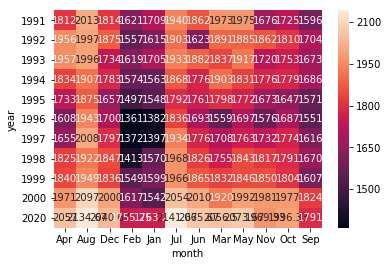

In [4]:
heatmap_y_month = pd.pivot_table(data=Amtrak,values="Ridership",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

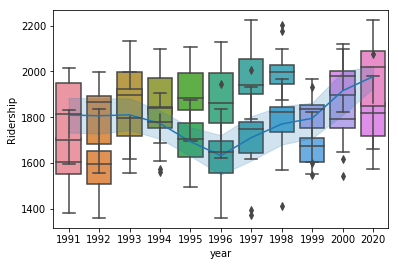

In [5]:
sns.boxplot(x="month",y="Ridership",data=Amtrak)
sns.boxplot(x="year",y="Ridership",data=Amtrak)
# sns.factorplot("month","Ridership",data=Amtrak,kind="box")

# Line plot for Ridership based on year
sns.lineplot(x="year",y="Ridership",data=Amtrak)

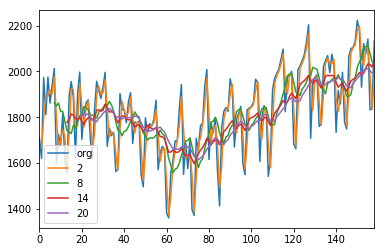

In [6]:
Amtrak.Ridership.plot(label="org")
for i in range(2,24,6):
    Amtrak["Ridership"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

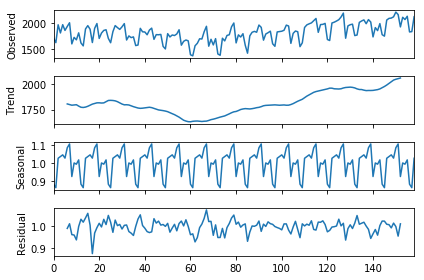

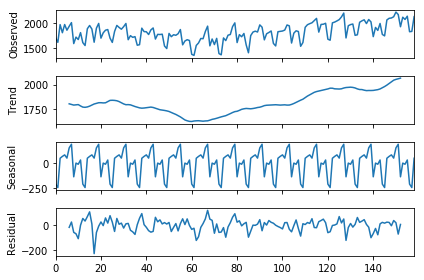

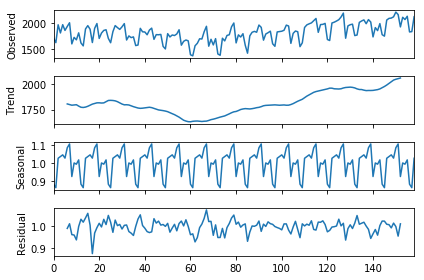

In [7]:
# Time series decomposition plot 
decompose_ts_add = seasonal_decompose(Amtrak.Ridership,model="additive",freq=12)
decompose_ts_add.plot()
decompose_ts_mul = seasonal_decompose(Amtrak.Ridership,model="multiplicative",freq=12)
decompose_ts_mul.plot()

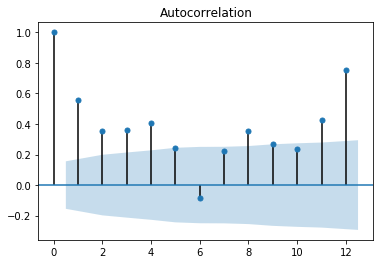

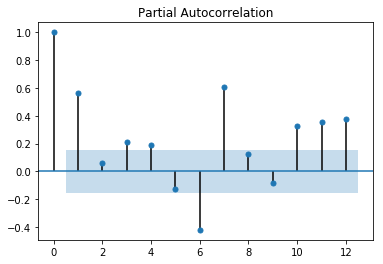

In [8]:
# ACF plots and PACF plots on Original data sets 
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(Amtrak.Ridership,lags=12)
tsa_plots.plot_pacf(Amtrak.Ridership,lags=12)

# Amtrak.index.freq = "MS" 
# splitting the data into Train and Test data and considering the last 12 months data as 
# Test data and left over data as train data 

Train = Amtrak.head(147)
Test = Amtrak.tail(12)
# to change the index value in panda

In [20]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)
Train["Ridership"] = Train["Ridership"].astype('double')



C:\Users\varun\Anacond\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
ses_model = SimpleExpSmoothing(Train["Ridership"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Ridership) # 7.846321

8.284195400284288

In [25]:
# Holt method 
hw_model = Holt(Train["Ridership"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Ridership) # 7.261176729658341

7.9811472110242585

In [29]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Ridership"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Ridership) # 4.500954

C:\Users\varun\Anacond\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


3.159669764222986

In [31]:
Train["Ridership"] = Train["Ridership"].astype('double')
Amtrak["Ridership"] = Amtrak["Ridership"].astype('double')
hwe_model_add_add = ExponentialSmoothing(Amtrak["Ridership"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Amtrak.index[0],end = Amtrak.index[-1])
pred_hwe_add_add

C:\Users\varun\Anacond\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\varun\Anacond\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


0      1697.714106
1      1658.269071
2      1942.130429
3      1952.643125
4      1929.958849
5      1894.406037
6      1962.473019
7      2008.932543
8      1699.265002
9      1774.309744
10     1723.351955
11     1734.450118
12     1555.831110
13     1540.556132
14     1858.525587
15     1860.155568
16     1981.120228
17     1861.727202
18     1814.278663
19     1924.813609
20     1647.347903
21     1815.445038
22     1789.278501
23     1875.173834
24     1650.537124
25     1630.176734
26     1933.520662
27     1866.189859
28     1973.369551
29     1868.204973
          ...     
129    1914.235274
130    1919.209183
131    1984.095858
132    1749.095360
133    1719.157643
134    2053.462089
135    2034.341374
136    2083.195619
137    2033.691763
138    2098.639868
139    2135.541618
140    1748.938986
141    1884.249664
142    1887.993439
143    1902.103541
144    1719.993785
145    1718.892473
146    2036.101237
147    2055.317637
148    2119.474882
149    2068.359224
150    2191.

In [32]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Ridership"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Ridership) # 4.109309

3.118475269462364